In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Análisis de una señal armónica

Ua señal armónica es aquella que tiene una única componente de Fourier. Este tipo de señales son teóricas, ya que se requiere que la duración sea infinita, pero se puede aproximar como se ve a continuación

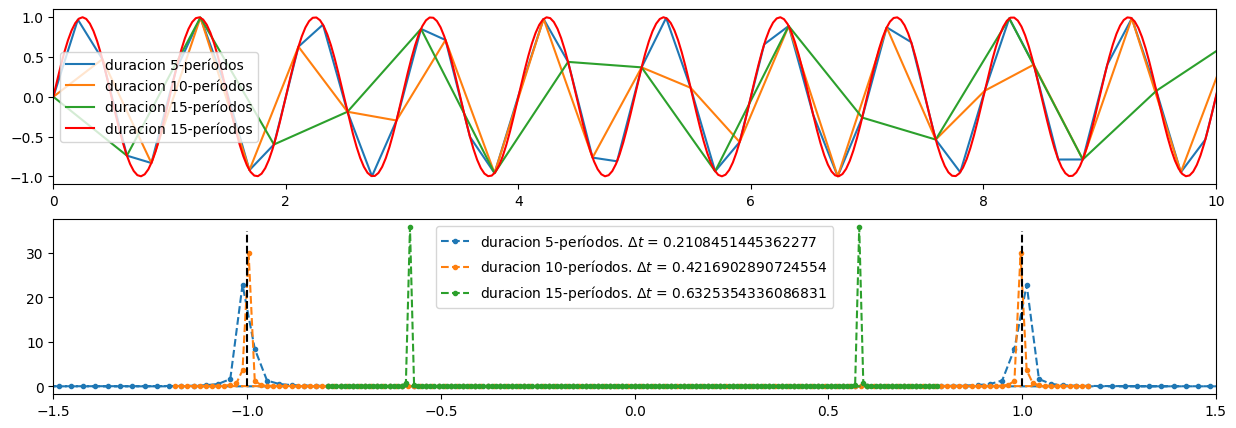

In [15]:
# Vamos a utilizar una cantidad fija de puntos, analizando mayor duración
n = 150 # numero de puntos
f = 1 # frecuencia
fig, axs = plt.subplots(2,1,figsize=(15,5))
for i in range(5,20,5):
    t = np.linspace(0, i * 2 * np.pi,n)    
    x = np.sin(2*np.pi*f*t)
    axs[0].plot(t,x,label=f'duracion {i}-períodos')
    dft = np.fft.fft(x, norm='ortho')
    freqs = np.fft.fftfreq(n,t[1]-t[0])
    axs[1].plot(freqs, np.abs(dft)**2, '--o', ms  =3, label = f'duracion {i}-períodos. $\Delta t$ = {t[1]-t[0]}')
axs[0].set_xlim(0,10)
n = 3000 # numero de puntos
f = 1 # frecuencia
t = np.linspace(0, 15 * 2 * np.pi,n)    
x = np.sin(2*np.pi*f*t)
axs[0].plot(t,x,'r-',label=f'duracion {15}-períodos')
axs[0].legend()
axs[1].vlines([-1,1],0,35, colors='k',linestyles='dashed')
axs[1].set_xlim(-1.5,1.5)
axs[1].legend()
plt.show()

* La función seno se puede escribir como $sin(x) = \frac{exp(ix)-exp(-ix)}{2i}$, por lo que en el caso anterior se encuentran las frecuencias f = {1,-1}. 
* Es importante notar el factor $2\pi$ que acompaña a la frecuencia. 
* La frecuencia máxima posible estará determinada por $\Delta t$ y el número total de puntos
* No siempre se puede encontrar la frecuencia exacta de la serie temporal, esta debe coincidir con la discretización temporal y de frecuencia. La razón de la falta de posibilidad de representar algunas frecuencias está dada por la denominada frecuencia de **Nyquist**, el caso de 15 períodos con pocos puntos, donde la frecuencia que se observa es ficticia y está dada sólo por un efecto de discretización.

## Estimación de la estacionalidad de una ST

El siguiente ejemplo es de los valores del acelerómetro de un teléfono móvil al caminar. 

Es importante recordar que por los factores $2 \pi$ de la definición del algoritmo FFT, el período de oscilación se obtiene como
$$
\tau = \frac{1}{f}
$$


In [16]:
import csv

# datos del acelerometro del telefono movil al caminar
with open('../../Data/acelerometro/caminata-ejemplo.csv', 'r') as fp:
    reader = csv.reader(fp, delimiter=';')
    col_names = next(reader)
    data = []
    for row in reader:
        data.append([float(r) for r in row])
data = np.array(data)
time = data[:,0]
signal_x = data[:,1]
print(time[:10])

[0.00236734 0.00305818 0.00344318 0.00396255 0.00505089 0.00530917
 0.00553057 0.01163896 0.01210511 0.01234198]


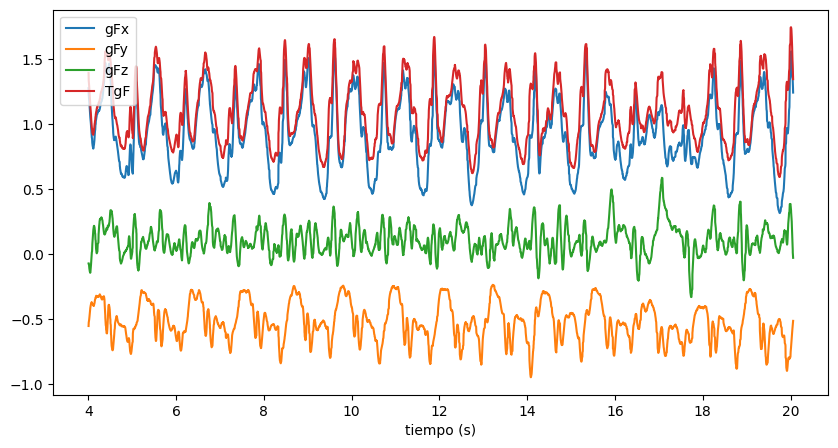

In [17]:
plt.figure(figsize=(10,5))
plt.xlabel('tiempo (s)')
for i in range(len(col_names)-1):
    plt.plot(data[2000:10000,0],data[2000:10000,i+1], label=col_names[i+1])
plt.legend()

Para hacer un análisis mediante la FFT, primero hay que tener intervalos de tiempo regulares, el sampleo debe realizarse con frecuencia constante. En este ejemplo puede verse que no es el caso. Si bien existen técnicas de estimación, en este ejemplo tomaremos una estrategia simple: vamos a hacer un resampleo de la serie temporal mediante interpolaciones para obtener los valores de la serie en intervalos regulares.

Primero veamos el sampleo de la grilla temporal

min dt: 0.00015567700000218565 - max dt: 0.02275745000000029


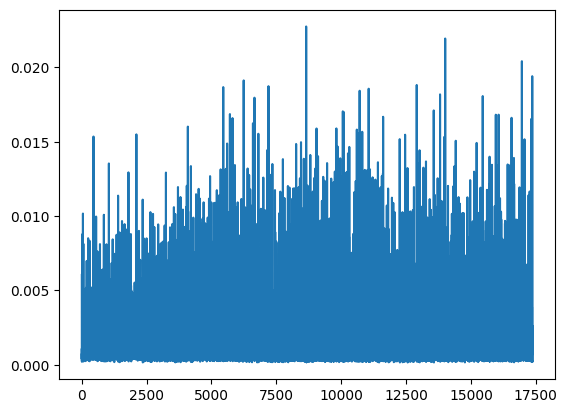

In [18]:
dt = time[1:]-time[:-1]
print(f'min dt: {dt.min()} - max dt: {dt.max()}')
plt.plot(dt)

Dado que la diferencia entre los espaciados temporales oscilan entre 1.5e-4 s y 2.4e-2 s (2 ordenes de magnitud), tomaremos un valor cercano al maximo, en este caso 2e-2 s

grilla experimental
comienzo: 0.002367344s. final: 34.87031462s. N de puntos: 17381
------------------
grilla resampleada
comienzo: 0.002367344s. final: 34.852367344s. N de puntos: 3486


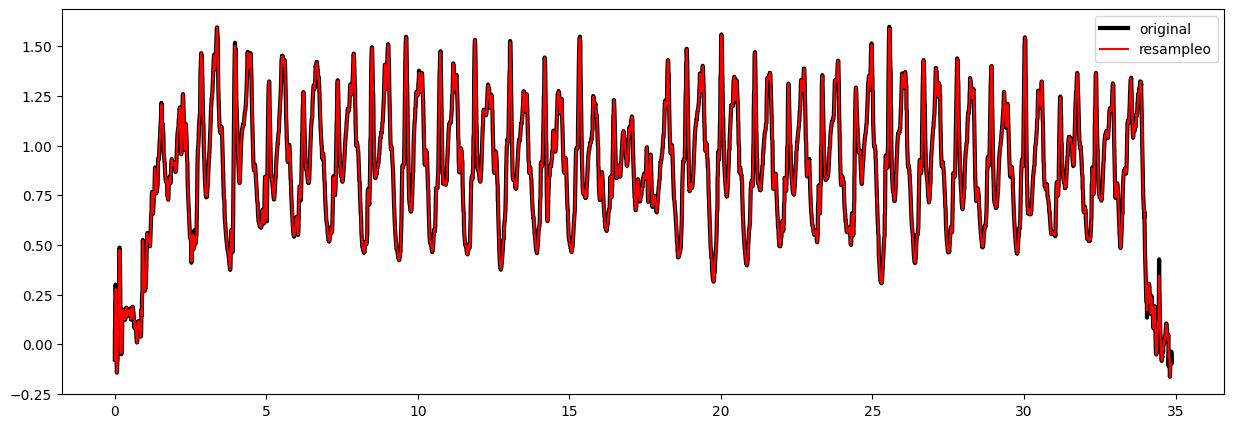

In [19]:
from scipy.interpolate import interp1d
# interpolamos
f = interp1d(time, signal_x, kind = 'linear')
print('grilla experimental')
print(f'comienzo: {time[0]}s. final: {time[-1]}s. N de puntos: {len(time)}')
# necesitamos crear la nueva grilla de tiempo
delta_t = 1e-2 # esta es equiespaciada
n_grid = np.int64((time[-1]-time[0])/delta_t)
new_grid = np.arange(n_grid)*delta_t + time[0]
print('------------------')
print('grilla resampleada')
print(f'comienzo: {new_grid[0]}s. final: {new_grid[-1]}s. N de puntos: {len(new_grid)}')

new_signal_x = f(new_grid)
plt.figure(figsize=(15,5))
plt.plot(time, signal_x, 'k', lw = 3, label = 'original')
plt.plot(new_grid, new_signal_x, 'r', label = 'resampleo')
plt.legend()

Ahora con un sampleo uniforme, se puede hacer el análisis en el dominio de frecuencias. Ya hemos visto que la transformada completa de Fourier tiene las frecuencias positivas y negativas. Dada la simetría, descartaremos las frecuencias negativas

(0.0, 50.0)

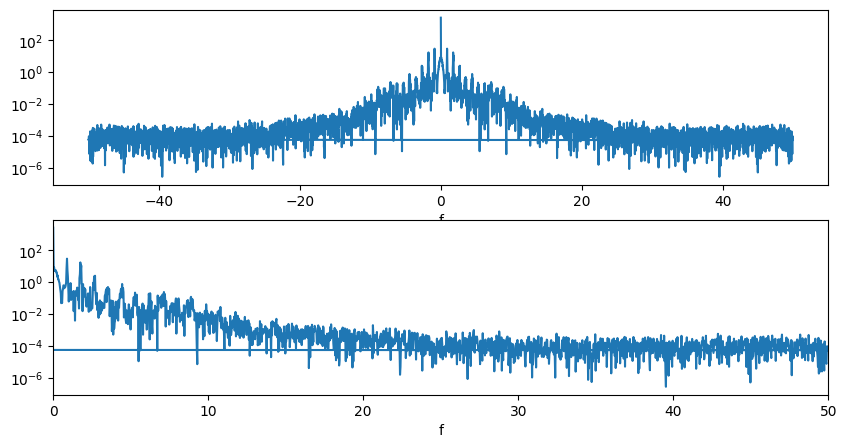

In [20]:
spectral_density = np.abs(np.fft.fft(new_signal_x, axis=0, norm='ortho'))**2
freqs = np.fft.fftfreq(new_grid.shape[0], delta_t)
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].set_xlabel('f')
axs[0].semilogy(freqs,spectral_density)
axs[1].set_xlabel('f')
axs[1].semilogy(freqs,spectral_density)
axs[1].set_xlim(0,50)

A partir del espectro de frecuencias, se puede estimar el ritmo de los pasos.

Encontremos las posiciones de los picos

Períodos de oscilación [ 17.43         1.12451613   0.57147541   0.37085106   0.28809917
   0.22490323   0.18945652   0.15990826   0.14        -0.14
  -0.15990826  -0.18945652  -0.22490323  -0.28809917  -0.37085106
  -0.57147541  -1.12451613 -17.43      ]


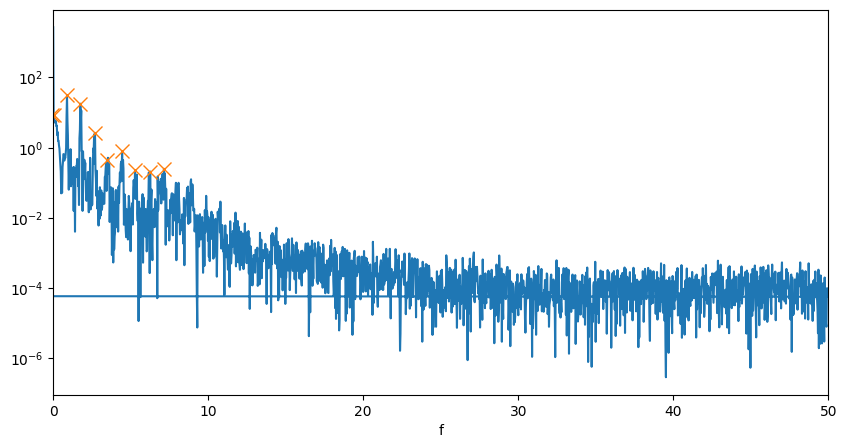

In [21]:
from scipy.signal import find_peaks
peaks = find_peaks(spectral_density,threshold=0.1, distance=20)[0]
print(f'Períodos de oscilación {1/freqs[peaks]}')
plt.figure(figsize=(10,5))
plt.xlabel('f')
plt.semilogy(freqs,spectral_density)
plt.semilogy(freqs[peaks],spectral_density[peaks],'x', ms=10)
plt.xlim(0,50)
plt.show()

In [22]:
# Podemos ver una aproximación extra a partir de suavizar la señal
#suavizamos con un filtro gaussiano la señal

def gauss(x, m, s):
    return np.exp(-(x-m)**2/2/s**2)/np.sqrt(2*np.pi)/s

plantilla = gauss(np.arange(13),6,3)
soft = np.hstack([np.zeros(6),np.convolve(spectral_density, plantilla, mode='valid'),np.zeros(6)])

Períodos de oscilación [ 5.81        1.12451613  0.56225806  0.37483871  0.14056452 -0.14056452
 -0.37483871 -0.56225806 -1.12451613 -4.98      ]


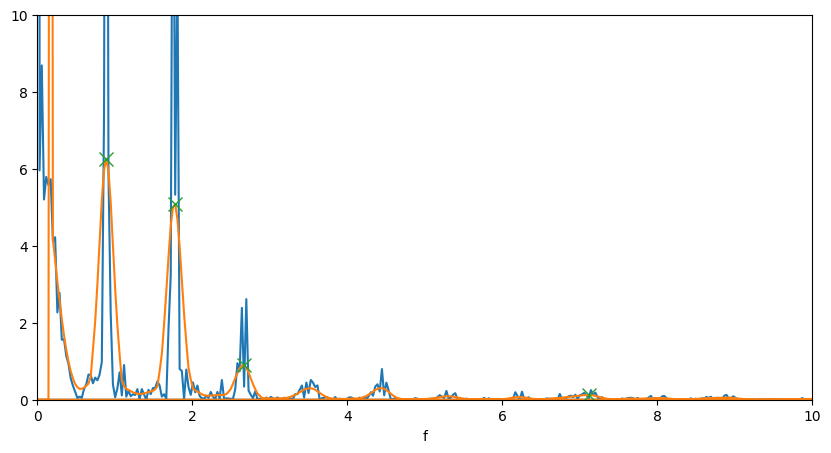

In [23]:
peaks = find_peaks(soft,threshold=0.001, distance=10)[0]
print(f'Períodos de oscilación {1/freqs[peaks]}')
plt.figure(figsize=(10,5))
plt.xlabel('f')
plt.plot(freqs,spectral_density)
plt.plot(freqs,soft)
plt.plot(freqs[peaks],soft[peaks],'x', ms=10)
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

Se puede inferir que el primer pico es espúreo, que surge ddel proceso de convolucion para el filtrado de la señal. Luego los dos segundos picos de frecuencia tienen magnitudes similares, por lo que determinan la principal componente oscilatoria de la serie.

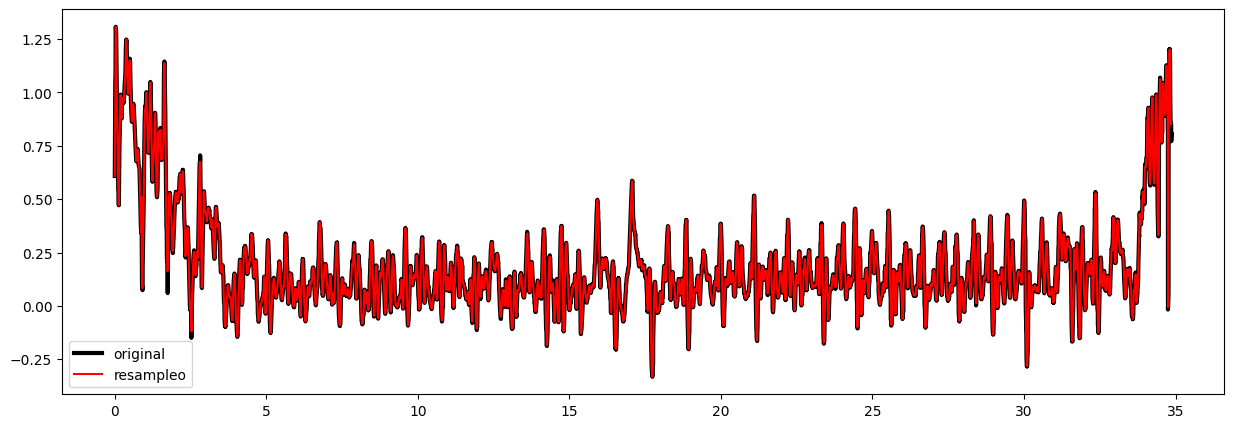

In [24]:
signal_y = data[:,3]
# interpolamos
f = interp1d(time, signal_y, kind = 'linear')
# necesitamos crear la nueva grilla de tiempo
delta_t = 1e-2 # esta es equiespaciado
n_grid = np.int64((time[-1]-time[0])/delta_t)
new_signal_y = f(new_grid)
plt.figure(figsize=(15,5))
plt.plot(time, signal_y, 'k', lw = 3, label = 'original')
plt.plot(new_grid, new_signal_y, 'r', label = 'resampleo')
plt.legend()

(0.0, 10.0)

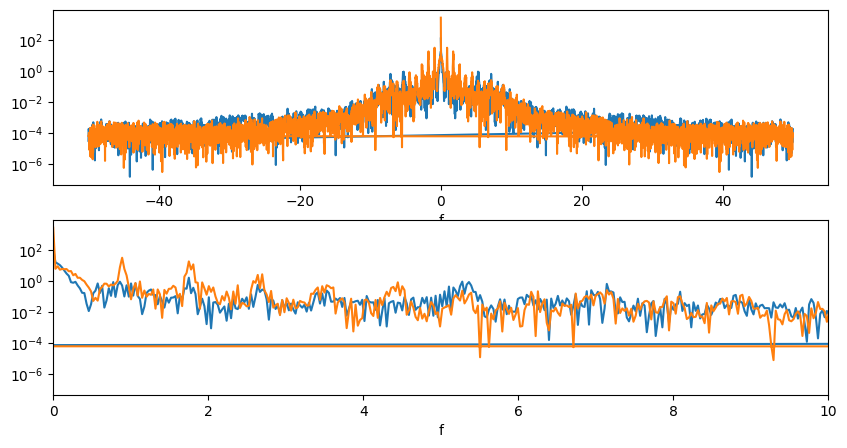

In [25]:
spectral_density_y = np.abs(np.fft.fft(new_signal_y, axis=0, norm='ortho'))**2
freqs = np.fft.fftfreq(new_grid.shape[0], delta_t)
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].set_xlabel('f')
axs[0].semilogy(freqs,spectral_density_y)
axs[0].semilogy(freqs,spectral_density)
axs[1].set_xlabel('f')
axs[1].semilogy(freqs,spectral_density_y)
axs[1].semilogy(freqs,spectral_density)
axs[1].set_xlim(0,10)

Períodos de oscilación [ 5.81        1.12451613  0.57147541  0.37483871  0.2857377   0.18741935
  0.14       -0.14       -0.18741935 -0.2857377  -0.37483871 -0.57147541
 -1.12451613 -4.98      ]


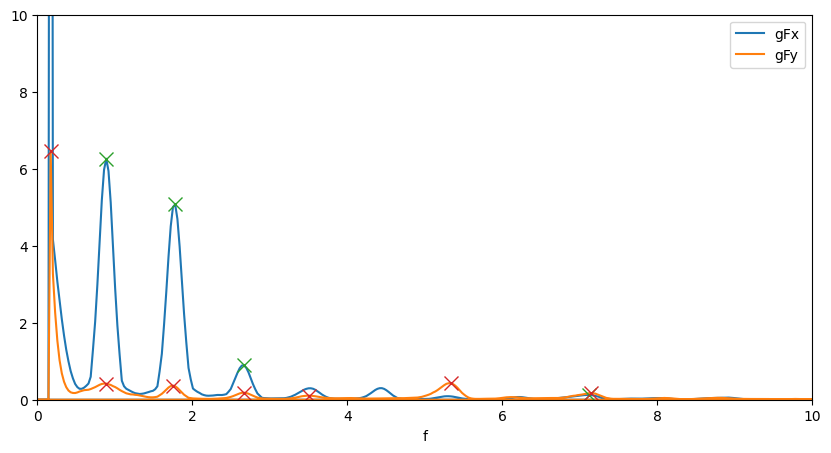

In [26]:

plantilla = gauss(np.arange(13),6,3)
soft_y = np.hstack([np.zeros(6),np.convolve(spectral_density_y, plantilla, mode='valid'),np.zeros(6)])
peaks_y = find_peaks(soft_y,threshold=0.001, distance=10)[0]
print(f'Períodos de oscilación {1/freqs[peaks_y]}')
plt.figure(figsize=(10,5))
plt.xlabel('f')
plt.plot(freqs,soft, label = 'gFx')
plt.plot(freqs,soft_y, label = 'gFy')
plt.plot(freqs[peaks],soft[peaks],'x', ms=10)
plt.plot(freqs[peaks_y],soft_y[peaks_y],'x', ms=10)
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()
plt.show()

# Espectrogramas
Para realizar un análisis en tiempo y frecuencia, se puede realizar la DFT sobre 
ventanas temporales consecutivas. La disminución en la discretización temporal estará relacionada 
con el tamaño de la ventana, y la cantidad de frecuencias involucradas.


In [27]:
from scipy.signal import spectrogram, get_window
help(spectrogram)
help(get_window)

Help on function spectrogram in module scipy.signal._spectral_py:

spectrogram(x, fs=1.0, window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')
    Compute a spectrogram with consecutive Fourier transforms.
    
    Spectrograms can be used as a way of visualizing the change of a
    nonstationary signal's frequency content over time.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length 

la frecuencia: 111.40846016432674 Hz. El pico de la FFT 111.4 Hz


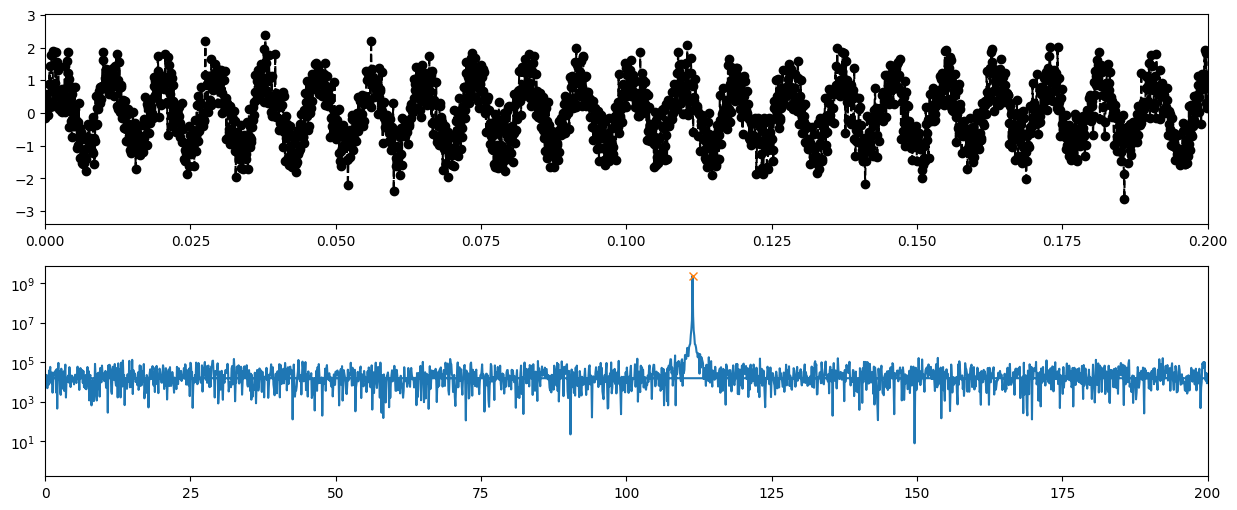

In [254]:
fs = 10e3
N = 1e5
dt = 0.0001 # intervalo de tiempo en segundos
t = np.arange(N)/fs
w = 700 # frecuencia angular en rpm
x =  np.sin(w * t) + np.random.normal(0, 0.5, size=len(t))
freqs = np.fft.fftfreq(len(t), dt)
dft = np.fft.fft(x, len(x))
fig, axs = plt.subplots(2,1, figsize = (15,6))
axs[0].plot(t,x, 'ko--')
axs[0].set_xlim(0,0.2)
axs[1].semilogy(freqs,np.abs(dft)**2)
axs[1].set_xlim(0,200)


peaks = find_peaks(np.abs(dft)**2,threshold=1000000, distance=10)[0]
axs[1].semilogy(freqs[peaks],np.abs(dft[peaks])**2, 'x')
print(f'la frecuencia: {w/2/np.pi} Hz. El pico de la FFT {freqs[peaks[0]]} Hz')


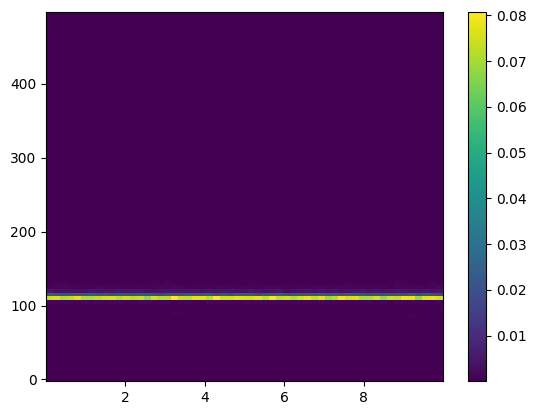

In [255]:
from matplotlib.colors import LogNorm
fs, ts, spec = spectrogram(x,1/dt,nperseg=2000)
plt.pcolormesh(ts,fs[:100],spec[:100,:])
plt.colorbar()

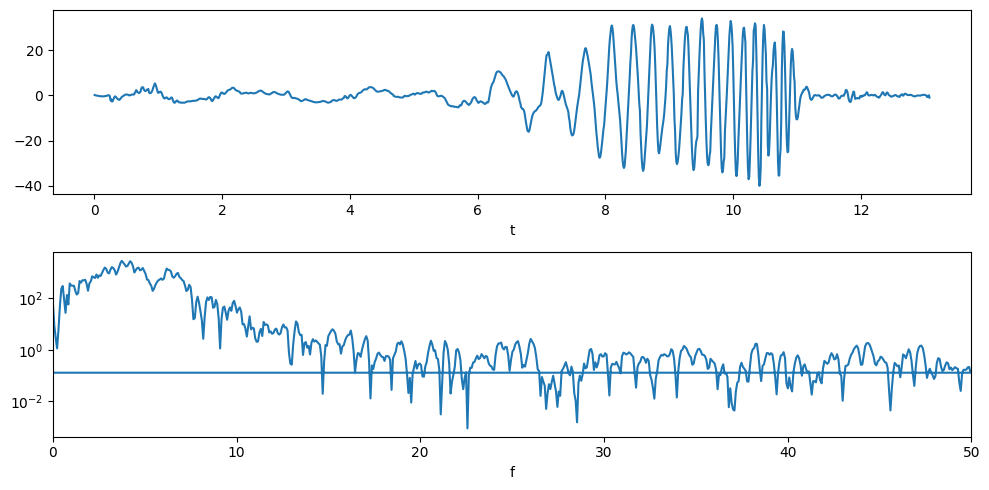

In [310]:
import csv

# datos del acelerometro del telefono movil al caminar
with open('../../Data/acelerometro/frec-var.csv', 'r') as fp:
    reader = csv.reader(fp, delimiter=';')
    col_names = next(reader)
    data = []
    for row in reader:
        data.append([float(r) for r in row])
data = np.array(data)
time = data[:,0]
signal_x = data[:,1]
# interpolamos
f = interp1d(time, signal_x, kind = 'linear')

# necesitamos crear la nueva grilla de tiempo
delta_t = 1e-2 # esta es equiespaciada
n_grid = np.int64((time[-1]-time[0])/delta_t)
new_grid = np.arange(n_grid)*delta_t + time[0]
new_signal_x = f(new_grid)


spectral_density = np.abs(np.fft.fft(new_signal_x, axis=0, norm='ortho'))**2
freqs = np.fft.fftfreq(new_grid.shape[0], delta_t)
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].set_xlabel('t')
axs[0].plot(new_grid,new_signal_x)
axs[1].set_xlabel('f')
axs[1].semilogy(freqs,spectral_density)
axs[1].set_xlim(0,50)
fig.tight_layout()


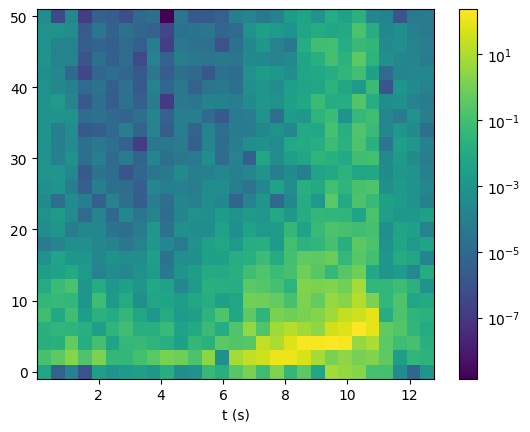

In [311]:
from matplotlib.colors import LogNorm
fs, ts, spec = spectrogram(new_signal_x,1/delta_t,nperseg=50)
plt.xlabel('t (s)')
plt.pcolormesh(ts,fs[0:],spec[0:,:],norm= LogNorm(vmin = spec.min(), vmax= spec.max()))
plt.colorbar()